In [150]:
from random import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from matplotlib import pyplot as plt
%matplotlib inline

r_seed = np.random.seed(0)

In [155]:
rand = np.random.randint(0., high = 47, size = 5)
rand

array([23,  6, 24, 24, 12])

Попробовать Label encoding

In [2]:
data_full = pd.read_excel(r'Задание (пролонгация).xlsx',
                          sheet_name='data_full')

In [3]:
data_full.head(3)

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,Иностранные,Челябинская область,NaN,TOYOTA,RAV 4,2018,Нет,Состоит в браке,...,42,24,1.00,1400000,M,0,55000,0.040,0,0
1,2,Магнитогорский,Отечественные,Челябинская область,NaN,LADA,GRANTA,2016,Нет,Состоит в браке,...,41,4,1.05,200000,M,0,10000,0.010,0,0
2,3,Ростовский,Отечественные,Ростовская область,NaN,LADA,GRANTA,2018,Нет,Не состоит в браке,...,49,20,0.95,400000,F,0,30000,0.065,1,1


In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10863 non-null  int64  
 1   Filial           10863 non-null  object 
 2   Type_ts          10863 non-null  object 
 3   passport_region  10863 non-null  object 
 4   VIP              284 non-null    object 
 5   Brand            10863 non-null  object 
 6   Model            10863 non-null  object 
 7   Yr_production    10863 non-null  int64  
 8   GAP              10863 non-null  object 
 9   married          10863 non-null  object 
 10  KBM              10863 non-null  int64  
 11  KBM_prol_est     10863 non-null  int64  
 12  delta_kbm        10863 non-null  int64  
 13  deduct           10863 non-null  object 
 14  deduct_amount    10863 non-null  object 
 15  product          10863 non-null  object 
 16  Bank             10863 non-null  object 
 17  channel - ma

In [5]:
data_full['VIP'].loc[data_full['VIP'].notna()].unique()

array(['Особый статус +', 'Особый статус'], dtype=object)

In [6]:
data_full['VIP'] = data_full['VIP'].replace(np.nan, 'Без статуса')

In [7]:
data_full['VIP'].loc[data_full['VIP'].notna()].unique()

array(['Без статуса', 'Особый статус +', 'Особый статус'], dtype=object)

In [8]:
print(data_full['sex'].unique())
print(data_full.shape)
data_full.drop(data_full[data_full['sex'] == ' '].index, inplace=True)
data_full.drop(data_full[data_full['passport_region'] == 'н.д.'].index,
               inplace=True)
print(data_full.shape)

['M' 'F' ' ']
(10863, 30)
(10851, 30)


In [9]:
data_full['Model'] = data_full['Model'].astype(str)

In [10]:
data_cat = data_full.select_dtypes(include='object')
data_num = data_full.select_dtypes(include=['int64', 'float64'])
data_num = data_num.drop('ID', axis=1)

In [11]:
data_num.head(3)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,2018,8,6,-2,42,24,1.00,1400000,0,55000,0.040,0,0
1,2016,8,6,-2,41,4,1.05,200000,0,10000,0.010,0,0
2,2018,8,6,-2,49,20,0.95,400000,0,30000,0.065,1,1


In [12]:
data_num.describe()

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,premium_car,price_gr,price_prc,OSAGO_clnt,target
count,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000,1.085100e+04,10851.000000,10851.000000,10851.000000,10851.000000,10851.000000
mean,2016.940466,7.058704,5.196019,-5.060547,43.688508,17.248825,1.000101,9.769975e+05,0.087273,32804.349830,0.033305,0.586305,-0.082297
std,1.546977,1.922403,1.735667,17.259764,11.248181,9.601594,0.050595,6.776986e+05,0.282248,19662.623634,0.016959,0.492518,0.715819
min,2009.000000,0.000000,0.000000,-100.000000,18.000000,0.000000,0.900000,0.000000e+00,0.000000,10000.000000,0.000000,0.000000,-1.000000
25%,2016.000000,6.000000,5.000000,-2.000000,35.000000,10.000000,1.000000,6.000000e+05,0.000000,15000.000000,0.020000,0.000000,-1.000000
50%,2018.000000,8.000000,6.000000,-2.000000,42.000000,16.000000,1.000000,8.000000e+05,0.000000,30000.000000,0.030000,1.000000,0.000000
75%,2018.000000,8.000000,6.000000,-2.000000,52.000000,22.000000,1.000000,1.200000e+06,0.000000,45000.000000,0.045000,1.000000,0.000000
max,2018.000000,12.000000,10.000000,2.000000,84.000000,63.000000,1.100000,3.000000e+06,1.000000,70000.000000,0.100000,1.000000,1.000000


Кандидаты в категориальные признаки:
KBM, KBM_prol_est, premium_car, discount, OSAGO_clnt, delta_kbm

In [13]:
possible_cats = ['KBM', 'KBM_prol_est', 'premium_car',
                 'discount', 'OSAGO_clnt', 'delta_kbm']
for category in possible_cats:
    print(f'Уникальные значения {category} - {data_full[category].unique()}')

Уникальные значения KBM - [ 8  6  0  2  4  1  5  7  9  3 12 10 11]
Уникальные значения KBM_prol_est - [ 6  4  0  5  2  7  3  9  1  8 10]
Уникальные значения premium_car - [0 1]
Уникальные значения discount - [1.   1.05 0.95 1.1  0.9 ]
Уникальные значения OSAGO_clnt - [0 1]
Уникальные значения delta_kbm - [  -2 -100   -1    1    0    2]


In [14]:
pd.concat([data_cat, data_num['OSAGO_clnt'], data_num['premium_car']], axis=1)
data_num = data_num.drop(['OSAGO_clnt', 'premium_car'], axis=1)

In [15]:
data_cat.head(3)

,Filial,Type_ts,passport_region,VIP,Brand,Model,GAP,married,deduct,deduct_amount,product,Bank,channel - map,category,kvs_type,sex
0,Магнитогорский,Иностранные,Челябинская область,Без статуса,TOYOTA,RAV 4,Нет,Состоит в браке,Франшиза 2-ой страховой случай,20000+,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,M
1,Магнитогорский,Отечественные,Челябинская область,Без статуса,LADA,GRANTA,Нет,Состоит в браке,Без франшизы,0,Компакт,Банк,Автосалоны,RN,Водители согласно перечню,M
2,Ростовский,Отечественные,Ростовская область,Без статуса,LADA,GRANTA,Нет,Не состоит в браке,Без франшизы,0,Классика,Банк,Автосалоны,NB 0-1,Водители согласно перечню,F


In [57]:
pd.options.mode.chained_assignment = None
data_cat[['OSAGO_clnt', 'premium_car', 'deduct_amount']] = data_full[[
    'OSAGO_clnt', 'premium_car', 'deduct_amount']].astype(str)
data_cat.describe(include='all')
data_full[['OSAGO_clnt', 'premium_car', 'deduct_amount']] = data_full[[
    'OSAGO_clnt', 'premium_car', 'deduct_amount']].astype(str)

In [17]:
data_cat[['OSAGO_clnt', 'premium_car']] = data_cat[['OSAGO_clnt', 'premium_car']].astype(str)

In [18]:
cat_cols = list(data_cat.columns)

for feature_name in cat_cols:
    print(data_cat.value_counts(feature_name))

Filial
Московский               3304
Краснодарский            1150
Санкт - Петербургский    1084
Ростовский                553
Воронежский               474
Казанский                 421
Самарский                 394
Магнитогорский            335
Челябинский               319
Пермский                  307
Ижевский                  276
Уфимский                  269
Нижегородский             268
Тверской                  251
Екатеринбургский          242
Ставропольский            234
Волгоградский             232
Новосибирский             185
Белгородский              182
Кемеровский               171
Тульский                  134
Дальневосточный            66
dtype: int64
Type_ts
Иностранные      8344
Отечественные    2507
dtype: int64
passport_region
Москва                          1611
Московская область              1164
Краснодарский край               936
Санкт-Петербург                  739
Ростовская область               544
                                ... 
Магаданская облас

In [20]:
data_full['VIP'].value_counts().index

Index(['Без статуса', 'Особый статус +', 'Особый статус'], dtype='object')

In [ ]:
data_train = data_full[(data_full['target'] == 1) | (data_full['target'] == 0)]
data_train

In [21]:
data_1 = data_full[data_full['target'] == 1]
data_0 = data_full[data_full['target'] == 0]

In [22]:
data_1['product'].value_counts()

Классика     1632
Компакт       517
Уверенный     221
Name: product, dtype: int64

In [23]:
def cat_plot(col_list, height=1, width=1, figsize=(20, 35),
             sharey=False, title='Распределение категориальных признаков',
             data_1=data_1, data_0=data_0, h_bars=[], long_labels=[]):

    fig, axes = plt.subplots(height, width, figsize=figsize, sharey=sharey)
    if (height > 1) or (width > 1):
        axes = axes.ravel()
    else:
        axes = [axes]

    fig.suptitle(title, y=0.92,
                 fontsize=18, fontweight='bold')

    for ax, cat_col in zip(axes, col_list):

        val_1 = data_1[cat_col].value_counts()
        val_0 = data_0[cat_col].value_counts()

        if cat_col in h_bars:

            hbars_0 = ax.barh(width=val_0,
                              y=range(len(val_0.index)),
                              color='royalblue',
                              alpha=0.8,
                              label='Не пролонгирован')

            hbars_1 = ax.barh(width=val_1,
                              y=range(len(val_1.index)),
                              color='darkgray',
                              label='Пролонгирован')
            ax.set_ylim(bottom=-1, top=len(val_0.index))

            for bar_1, bar_0 in zip(hbars_1, hbars_0):
                x_val1 = bar_1.get_width()
                y_val1 = bar_1.get_y()
                x_val0 = bar_0.get_width()
                y_val0 = bar_0.get_y()

                ax.text(x_val1*1.01,
                        y_val1,
                        x_val1,
                        color='black',
                        fontweight='bold')

                ax.text(x_val0+3,
                        y_val0,
                        f"{x_val0}({(x_val1/(x_val1+x_val0)*100):.1f}%)",
                        color='darkblue',
                        fontweight='bold')
            ax.set_yticks(range(len(val_0.index)))
            ax.set_yticklabels(list(val_0.index))

        else:

            bars_0 = ax.bar(height=val_0,
                            x=range(len(val_0.index)),
                            color='royalblue',
                            alpha=0.8,
                            label='Не пролонгирован')

            bars_1 = ax.bar(height=val_1,
                            x=range(len(val_1.index)),
                            color='darkgray',
                            label='Пролонгирован')

            ax.set_xticks(range(len(val_0.index)))

            if cat_col in long_labels:
                ax.set_xticklabels(list(val_0.index), rotation=-15, ha='left')
            else:
                ax.set_xticklabels(list(val_0.index))

            for bar_1, bar_0 in zip(bars_1, bars_0):

                y_val1 = bar_1.get_height()
                y_val0 = bar_0.get_height()

                ax.text(bar_1.get_x()+0.45*bar_1.get_width(),
                        y_val1 * 1.03,
                        y_val1,
                        color='black',
                        fontweight='bold')

                ax.text(bar_0.get_x(),
                        y_val0 * 1.01,
                        y_val0,
                        color='darkblue',
                        fontweight='bold')
                if (y_val1 + y_val0)/(len(data_1)+len(data_0)) > 0.025:
                    ax.text(bar_0.get_x(),
                            10,
                            f'({(y_val1/(y_val1+y_val0)*100):.1f}%)',
                            color='black',
                            fontweight='bold')
                else:
                    ax.text(bar_0.get_x(),
                            y_val0+ax.get_ylim()[1]*0.05,
                            f'({(y_val1/(y_val1+y_val0)*100):.1f}%)',
                            color='black',
                            fontweight='bold')

        ax.set_title(cat_col, fontsize=14, fontweight='bold')
        ax.legend(loc='upper right')

    for ax in axes[len(col_list):]:
        ax.remove()

    plt.show()

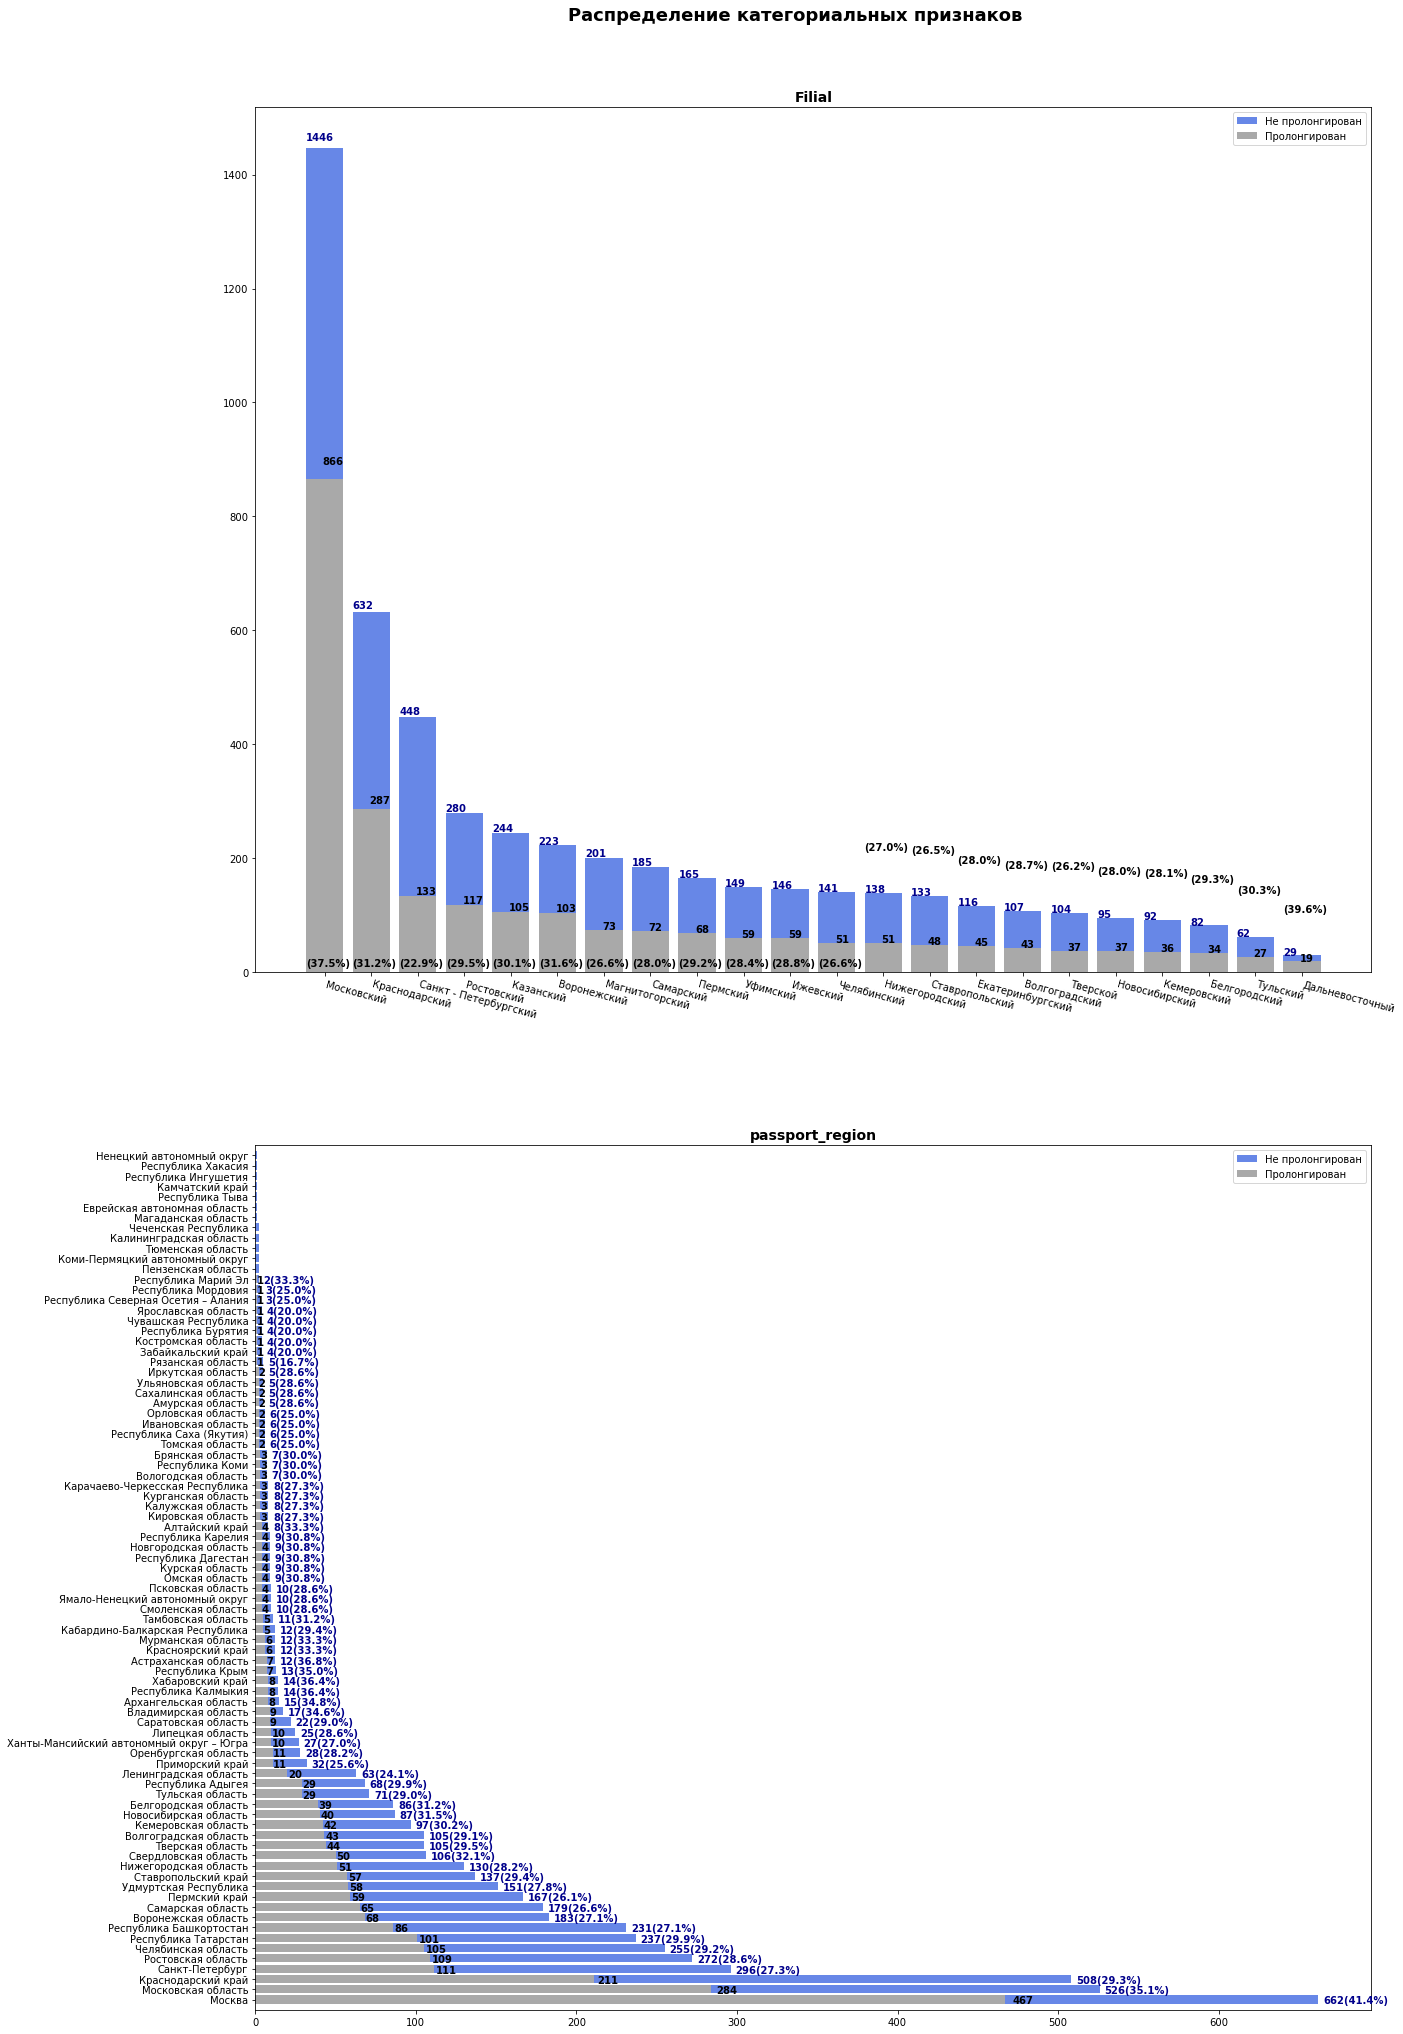

In [24]:
sub_cat = ['Filial', 'passport_region']
cat_plot(sub_cat, height=2, width=1, h_bars=['passport_region'], long_labels=['Filial'])

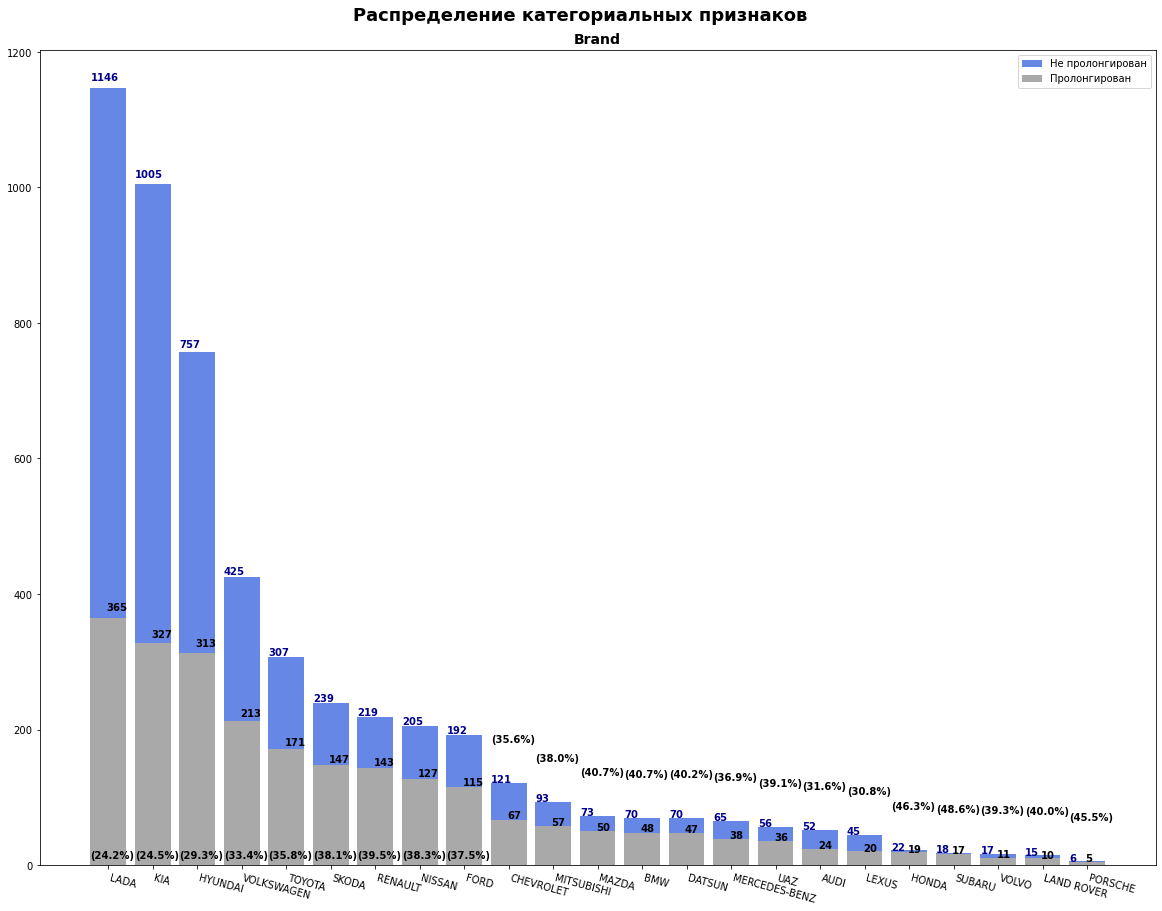

In [25]:
sub_cat = ['Brand']
cat_plot(sub_cat, height=1, width=1, long_labels=['Brand'], figsize=(20, 15))

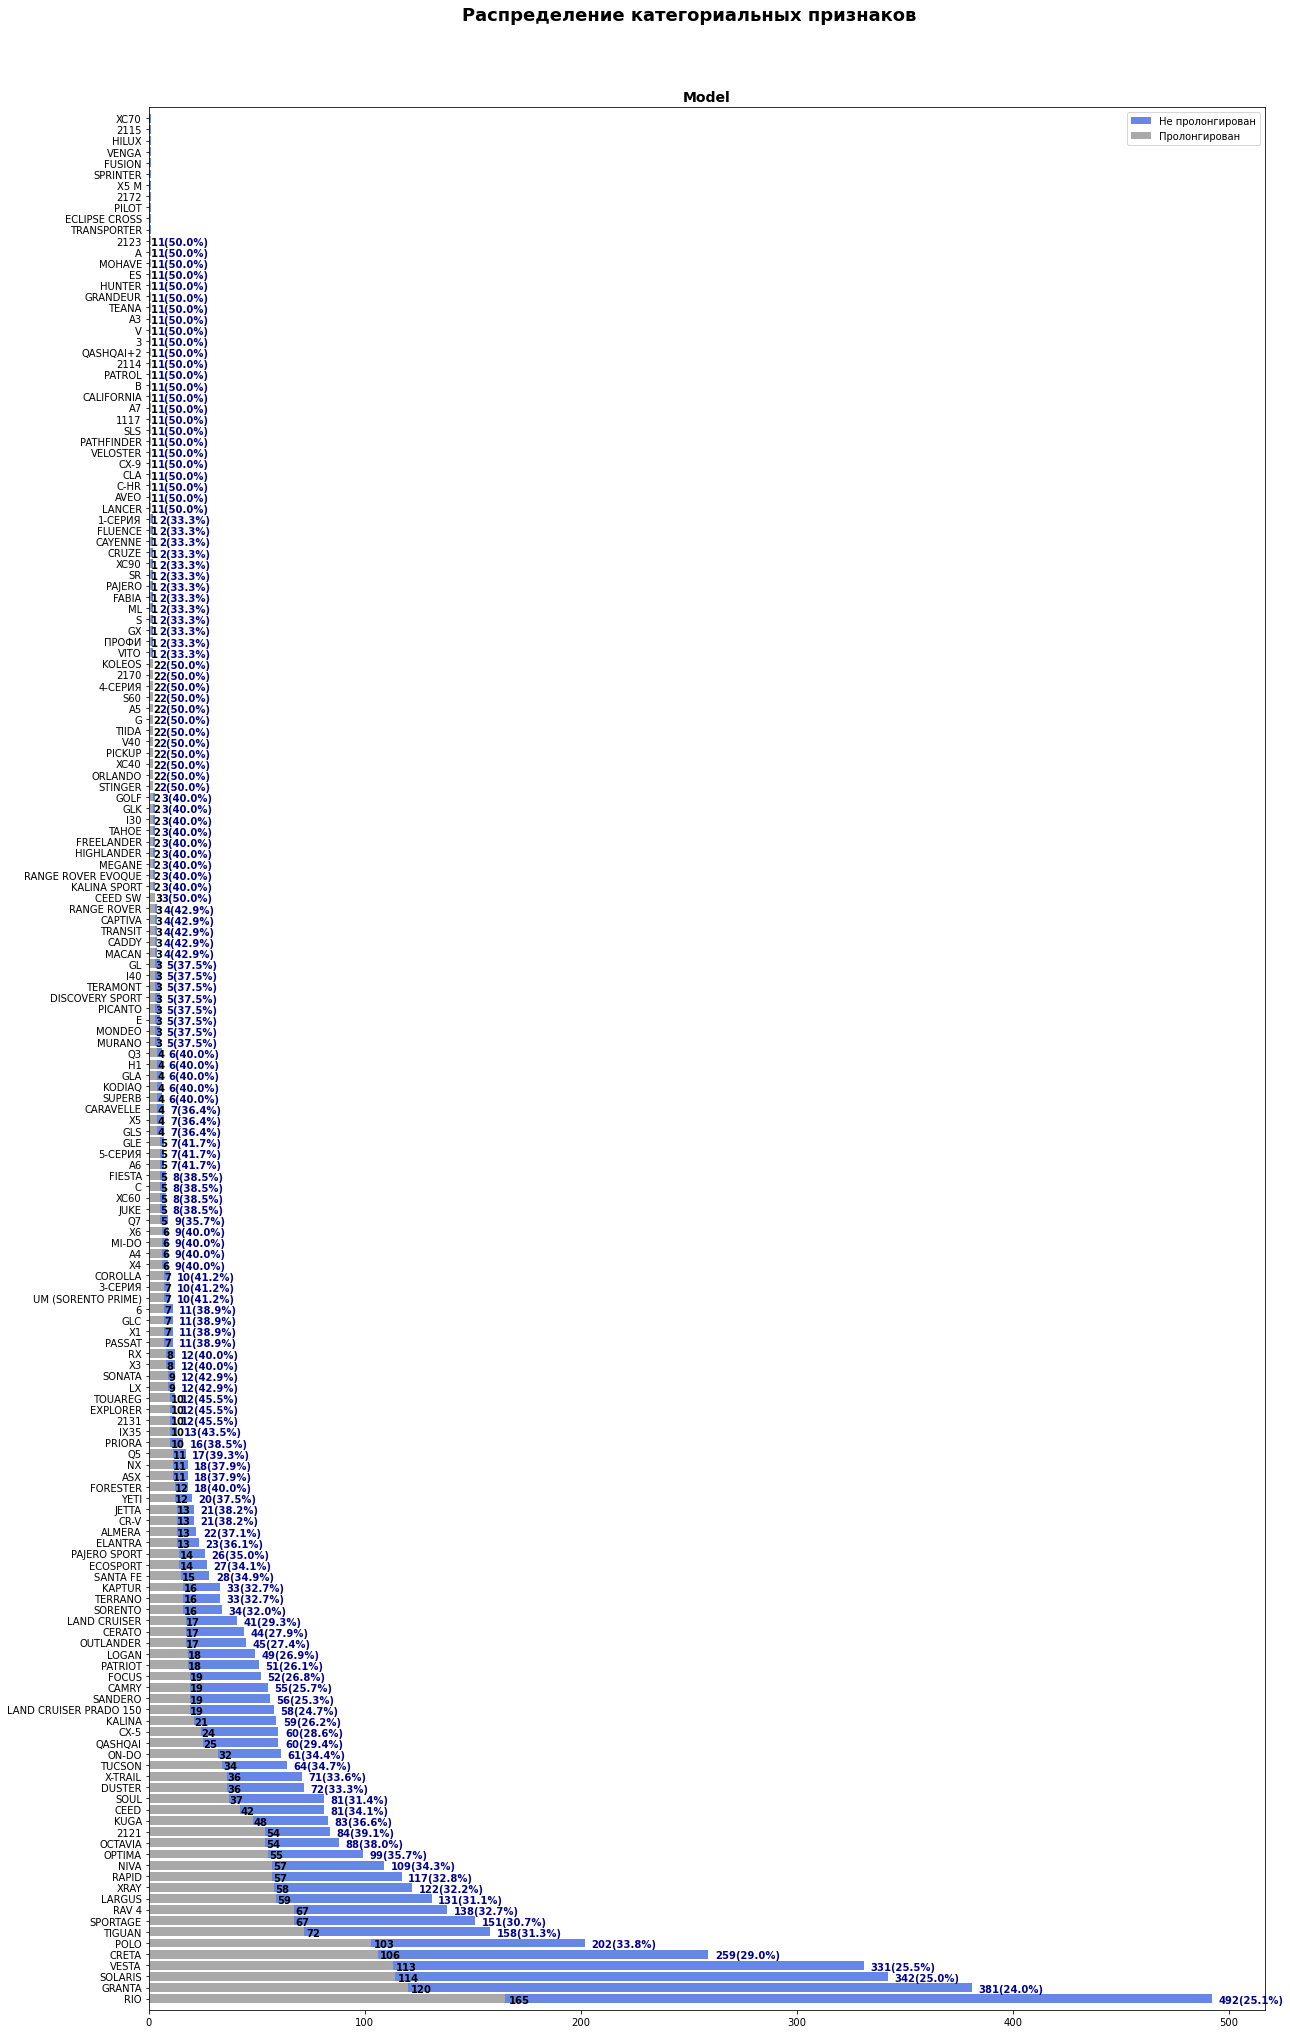

In [26]:
sub_cat = ['Model']
cat_plot(sub_cat, height=1, width=1, h_bars=['Model'], figsize=(20, 35))

In [240]:
data_short = data_train.copy()

In [211]:
print(data_short.shape)
rare_models = data_short['Model'].value_counts().loc[lambda x : x < 10].index
for model in rare_models:
    data_short.drop(data_short[data_short['Model'] == model].index,
               inplace=True)
print(data_short.shape)

(7588, 30)
(7277, 30)


In [217]:
print(data_short.loc[data_short['Model'] == 'JETTA'].index)
rand_ind = np.random.choice(data_short.loc[data_short['Model'] == 'JETTA'].index, size = 20)
data_short.loc[rand_ind, :]

Int64Index([ 157,  337,  361,  372,  421,  619,  722,  854,  887, 1429, 1492,
            1680, 1710, 2011, 2832, 3236, 4150, 4843, 5165, 5410, 5505, 5654,
            5680, 5866, 5942, 6286, 6556, 6811, 6916, 7334, 7350],
           dtype='int64')


,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
372,373,Краснодарский,Иностранные,Краснодарский край,Без статуса,VOLKSWAGEN,JETTA,2018,Нет,Состоит в браке,...,49,18,1.05,1000000,M,0,60000,0.050,1,0
1429,1430,Екатеринбургский,Иностранные,Смоленская область,Без статуса,VOLKSWAGEN,JETTA,2017,Нет,Состоит в браке,...,46,23,1.10,800000,M,0,25000,0.030,0,1
6811,6812,Челябинский,Иностранные,Челябинская область,Без статуса,VOLKSWAGEN,JETTA,2018,Нет,Состоит в браке,...,40,20,1.00,1200000,M,0,25000,0.020,1,0
421,422,Краснодарский,Иностранные,Краснодарский край,Без статуса,VOLKSWAGEN,JETTA,2017,Нет,Состоит в браке,...,43,15,0.90,1000000,F,0,50000,0.045,1,0
5942,5943,Ростовский,Иностранные,Ростовская область,Без статуса,VOLKSWAGEN,JETTA,2018,Нет,Состоит в браке,...,47,25,1.00,1000000,M,0,45000,0.045,1,0
5866,5867,Санкт - Петербургский,Иностранные,Санкт-Петербург,Без статуса,VOLKSWAGEN,JETTA,2015,Нет,Не состоит в браке,...,28,9,0.90,600000,F,0,15000,0.020,1,0
6286,6287,Санкт - Петербургский,Иностранные,Ленинградская область,Без статуса,VOLKSWAGEN,JETTA,2017,Нет,Состоит в браке,...,63,36,1.00,800000,M,0,35000,0.035,0,0
854,855,Московский,Иностранные,Московская область,Без статуса,VOLKSWAGEN,JETTA,2010,Нет,Не состоит в браке,...,62,21,1.00,200000,M,0,20000,0.060,1,1
157,158,Челябинский,Иностранные,Челябинская область,Без статуса,VOLKSWAGEN,JETTA,2017,Нет,Состоит в браке,...,52,19,1.00,1000000,M,0,35000,0.035,1,0
722,723,Уфимский,Иностранные,Республика Башкортостан,Без статуса,VOLKSWAGEN,JETTA,2017,Нет,Состоит в браке,...,42,10,0.90,800000,M,0,25000,0.030,0,0


In [234]:
def oversampler(data, ovr_cols=[], min_val=10, ovr_val=50):
    print(f'Initial shape - {data.shape}')
    for col in ovr_cols:

        rare_values = data[col].value_counts().loc[lambda x: x < min_val].index
        
        for val in rare_values:
            data.drop(data[data[col] == model].index,
                      inplace=True)
        print(f'Shape after decreasing {col} - {data.shape}')
        
        count_model = data[col].value_counts().loc[\
            lambda x: (x > min_val) & (x < ovr_val)]
        ovr_model = count_model.index
        
        for count, model in zip(count_model, ovr_model):
            indexes = data.loc[data[col] == model].index
            rand_ind = np.random.choice(indexes, size=ovr_val - count)
            data_rand = data.loc[rand_ind, :].copy()
            data = data.append(data_rand)
        print(f'Shape after upsampling {col} - {data.shape}')
    return data

In [ ]:
sub_cat = ['Model']
cat_plot(sub_cat, height=1, width=1, h_bars=['Model'], figsize=(20, 35))

In [ ]:
data_full.drop(data_full[data_full['passport_region'] == 'н.д.'].index,
               inplace=True)

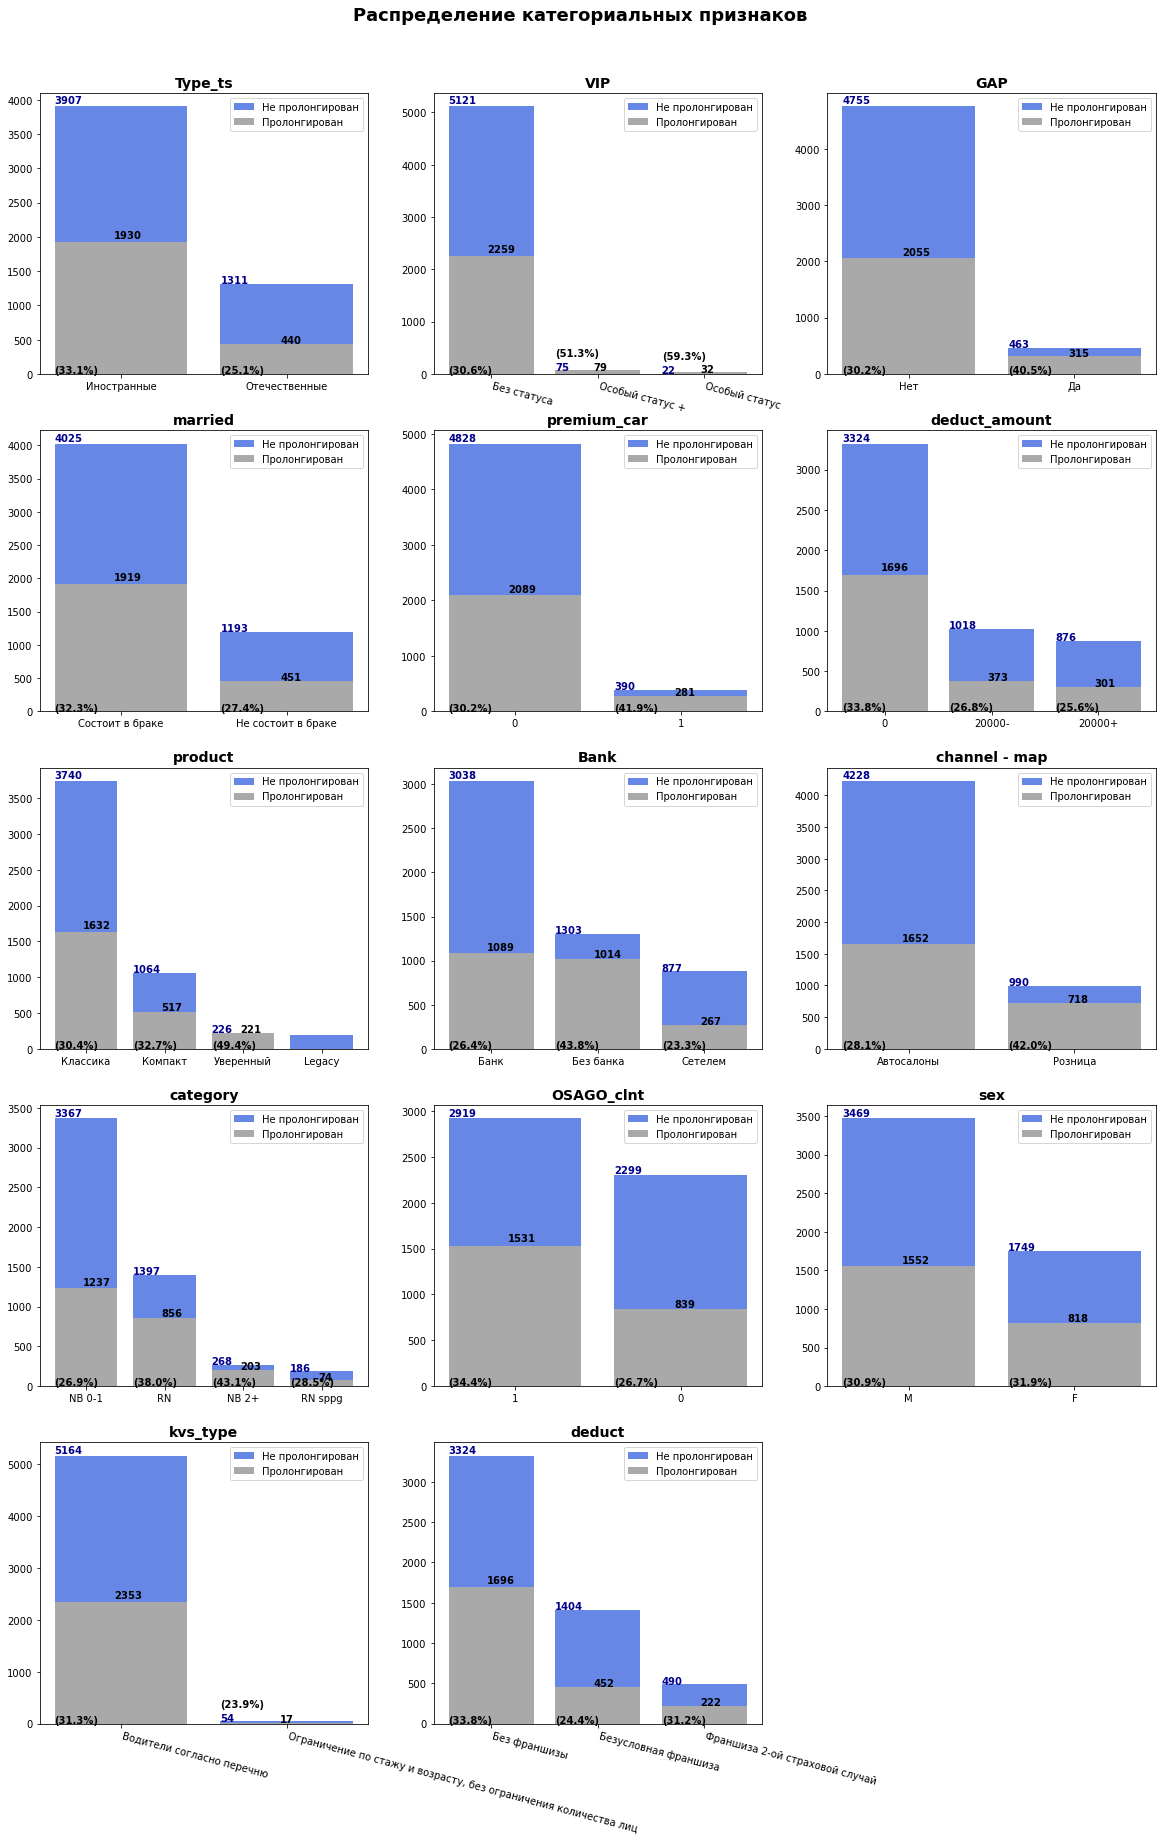

In [27]:
sub_cat = [cat_cols[1], cat_cols[3]]
sub_cat.extend(cat_cols[6:])
sub_cat[4], sub_cat[10], sub_cat[-1], sub_cat[-2] = sub_cat[-1], sub_cat[-2], sub_cat[4], sub_cat[10]
cat_plot(sub_cat, height=5, width=3,
         long_labels=['VIP', 'deduct', 'kvs_type'], figsize=(20, 30))

In [178]:
data_short['Model'].value_counts()

RIO            914
GRANTA         726
SOLARIS        630
VESTA          612
CRETA          538
              ... 
CAPTIVA         11
MURANO          11
KOLEOS          10
RANGE ROVER     10
3               10
Name: Model, Length: 100, dtype: int64

In [231]:

data_short_1 = data_short.loc[data_short['target'] == 1]
data_short_0 = data_short.loc[data_short['target'] == 0]

In [228]:
data_1['Model'].value_counts()

RIO        165
CRETA      120
TIGUAN     114
GRANTA     113
SOLARIS    106
          ... 
PRIORA       6
LX           4
GLA          4
GLS          3
FIESTA       2
Name: Model, Length: 88, dtype: int64

In [229]:
data_0['Model'].value_counts()

RIO        492
GRANTA     381
SOLARIS    342
VESTA      331
CRETA      259
          ... 
KODIAQ      16
TIIDA       10
FIESTA       8
GLS          7
GLA          6
Name: Model, Length: 88, dtype: int64

In [236]:
def oversampler(data, ovr_cols=[], min_val=10, ovr_val=100):
    print(f'Initial shape - {data.shape}')
    for col in ovr_cols:

        rare_values = data[col].value_counts().loc[lambda x: x < min_val].index
        
        for val in rare_values:
            data.drop(data[data[col] == val].index,
                      inplace=True)
        print(f'Shape after decreasing {col} - {data.shape}')
        
        count_model = data[col].value_counts().loc[\
            lambda x: (x > min_val) & (x < ovr_val)]
        ovr_model = count_model.index
        
        for count, model in zip(count_model, ovr_model):
            indexes = data.loc[data[col] == model].index
            rand_ind = np.random.choice(indexes, size=ovr_val - count)
            data_rand = data.loc[rand_ind, :].copy()
            data = data.append(data_rand)
        print(f'Shape after upsampling {col} - {data.shape}')
    print('Process finished')
    return data

In [239]:
data_short = oversampler(data_short, ovr_cols=cat_cols)

Initial shape - (20560, 30)
Shape after decreasing Filial - (20560, 30)
Shape after upsampling Filial - (20560, 30)
Shape after decreasing Type_ts - (20560, 30)
Shape after upsampling Type_ts - (20560, 30)
Shape after decreasing passport_region - (20560, 30)
Shape after upsampling passport_region - (20560, 30)
Shape after decreasing VIP - (20560, 30)
Shape after upsampling VIP - (20560, 30)
Shape after decreasing Brand - (20560, 30)
Shape after upsampling Brand - (20560, 30)
Shape after decreasing Model - (20560, 30)
Shape after upsampling Model - (20560, 30)
Shape after decreasing GAP - (20560, 30)
Shape after upsampling GAP - (20560, 30)
Shape after decreasing married - (20560, 30)
Shape after upsampling married - (20560, 30)
Shape after decreasing deduct - (20560, 30)
Shape after upsampling deduct - (20560, 30)
Shape after decreasing deduct_amount - (20560, 30)
Shape after upsampling deduct_amount - (20560, 30)
Shape after decreasing product - (20560, 30)
Shape after upsampling prod

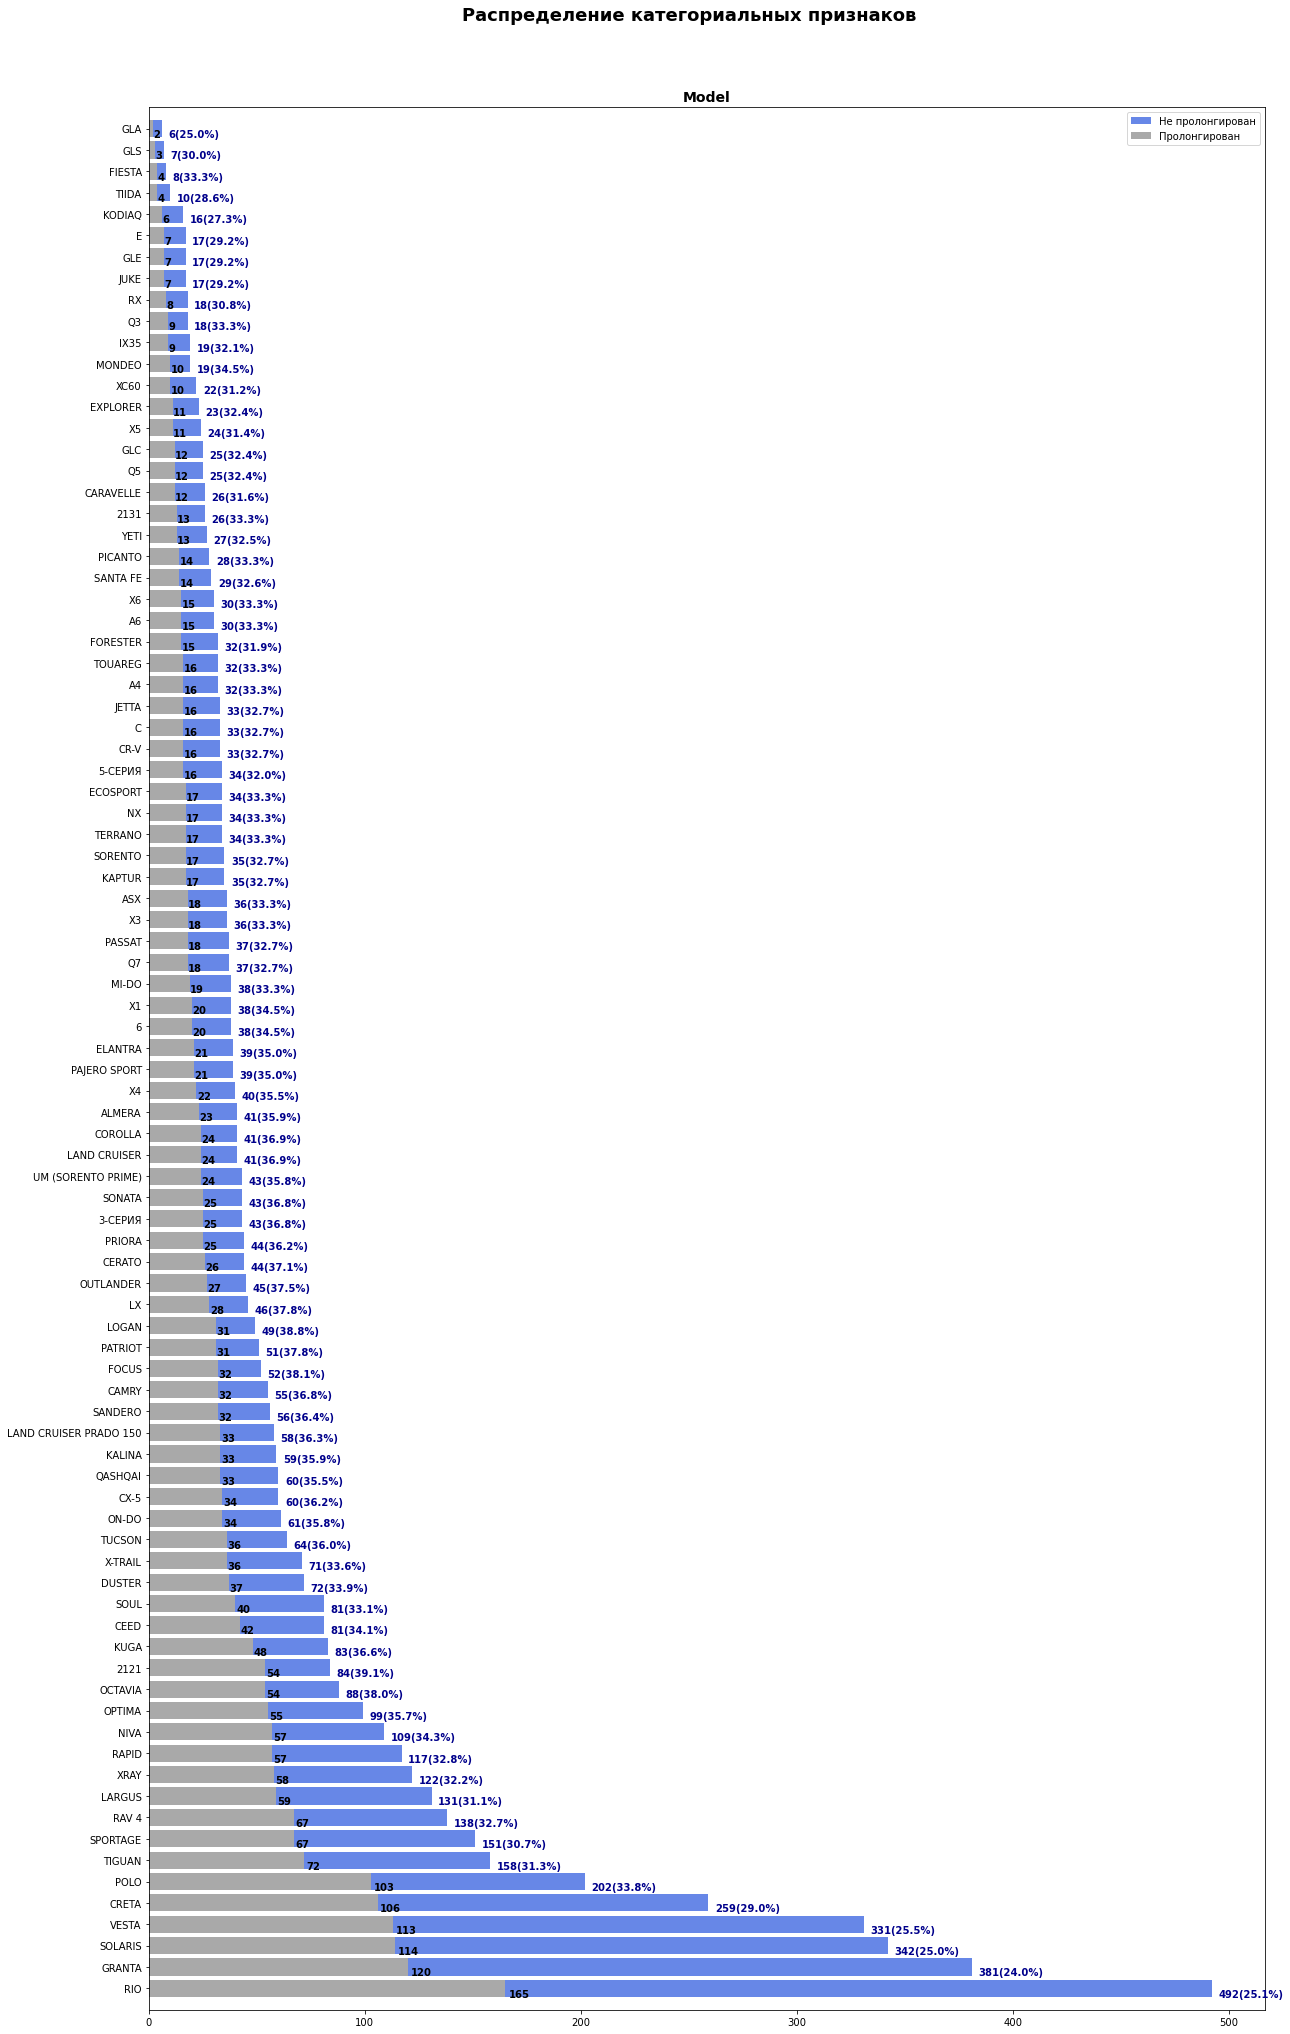

In [232]:
sub_cat = ['Model']
cat_plot(sub_cat,data_0=data_short_0, data_1=data_short_1, height=1, width=1, h_bars=['Model'], figsize=(20, 35))

,ID,Filial,Type_ts,passport_region,VIP,Brand,Model,Yr_production,GAP,married,...,Age,Exp,discount,Amount - gr,sex,premium_car,price_gr,price_prc,OSAGO_clnt,target
0,1,Магнитогорский,Иностранные,Челябинская область,Без статуса,TOYOTA,RAV 4,2018,Нет,Состоит в браке,...,42,24,1.00,1400000,M,0,55000,0.040,0,0
1,2,Магнитогорский,Отечественные,Челябинская область,Без статуса,LADA,GRANTA,2016,Нет,Состоит в браке,...,41,4,1.05,200000,M,0,10000,0.010,0,0
2,3,Ростовский,Отечественные,Ростовская область,Без статуса,LADA,GRANTA,2018,Нет,Не состоит в браке,...,49,20,0.95,400000,F,0,30000,0.065,1,1
3,4,Казанский,Иностранные,Республика Татарстан,Без статуса,KIA,RIO,2016,Нет,Не состоит в браке,...,40,15,1.10,400000,M,0,10000,0.020,1,0
4,5,Московский,Иностранные,Москва,Без статуса,DATSUN,ON-DO,2018,Нет,Состоит в браке,...,58,23,1.00,400000,M,0,10000,0.015,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,7594,Санкт - Петербургский,Отечественные,Ленинградская область,Без статуса,LADA,LARGUS,2018,Нет,Состоит в браке,...,40,10,1.00,600000,M,0,10000,0.010,0,0
7594,7595,Московский,Иностранные,Московская область,Без статуса,HYUNDAI,CRETA,2018,Нет,Состоит в браке,...,37,16,1.00,1000000,F,0,15000,0.010,0,0
7595,7596,Санкт - Петербургский,Иностранные,Санкт-Петербург,Без статуса,RENAULT,DUSTER,2018,Нет,Не состоит в браке,...,44,20,0.90,800000,M,0,45000,0.045,0,0
7596,7597,Ижевский,Отечественные,Удмуртская Республика,Без статуса,LADA,2121,2018,Нет,Не состоит в браке,...,34,15,1.00,400000,M,0,15000,0.030,1,0


In [29]:
num_cols = list(data_num.columns)
num_cols

['Yr_production',
 'KBM',
 'KBM_prol_est',
 'delta_kbm',
 'Age',
 'Exp',
 'discount',
 'Amount - gr',
 'price_gr',
 'price_prc',
 'target']

In [30]:
len(num_cols)

11

<AxesSubplot:>

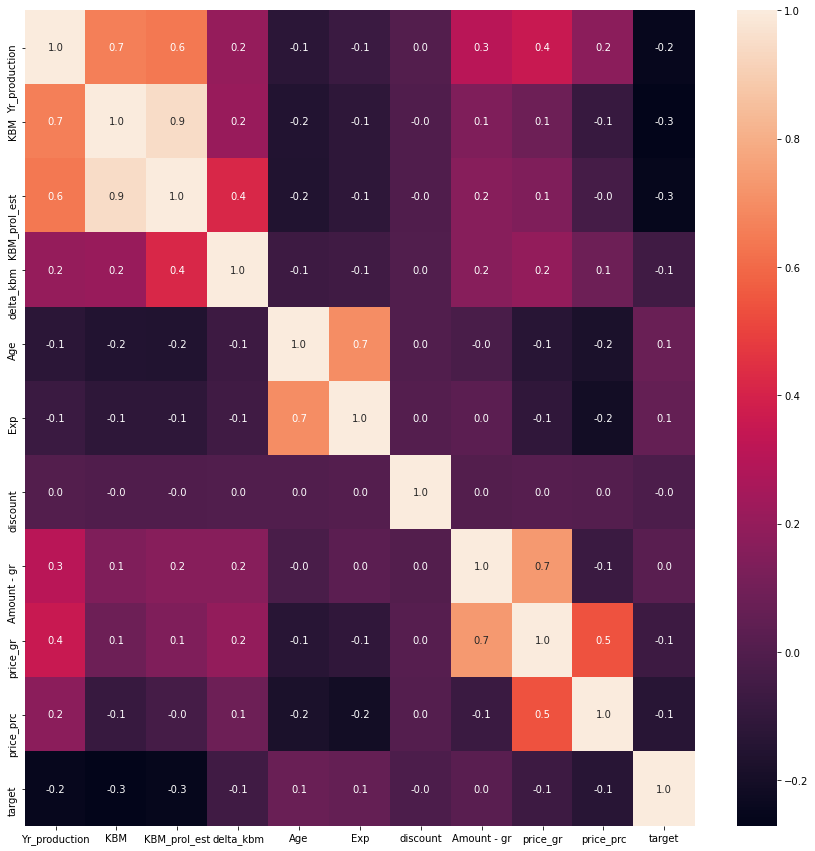

In [31]:
plt.figure(figsize=(15, 15))

sns.heatmap(data_train[num_cols].corr(method='spearman'), annot=True, fmt=".1f")

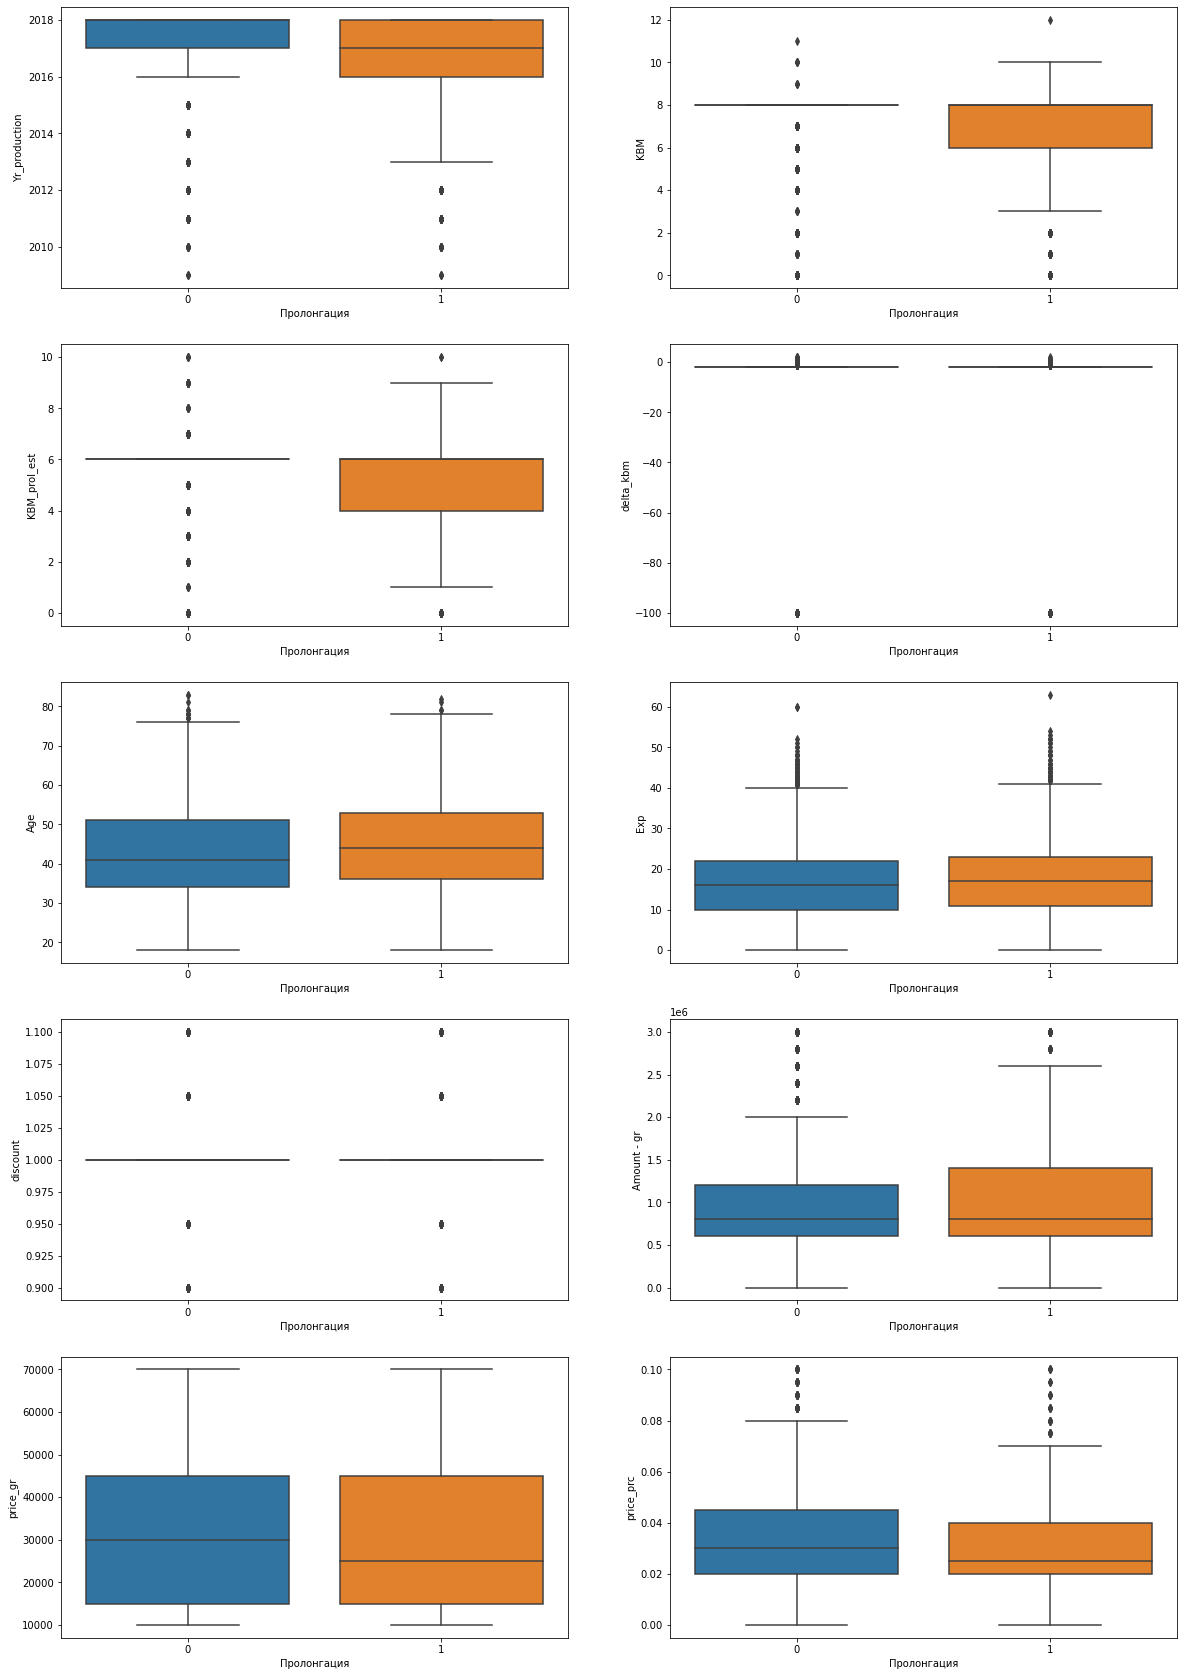

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

for idx, feat in enumerate(num_cols[:-1]):
    sns.boxplot(x='target', y=feat, data=data_train,
                ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_xlabel('Пролонгация')
    axes[idx // 2, idx % 2].set_ylabel(feat)

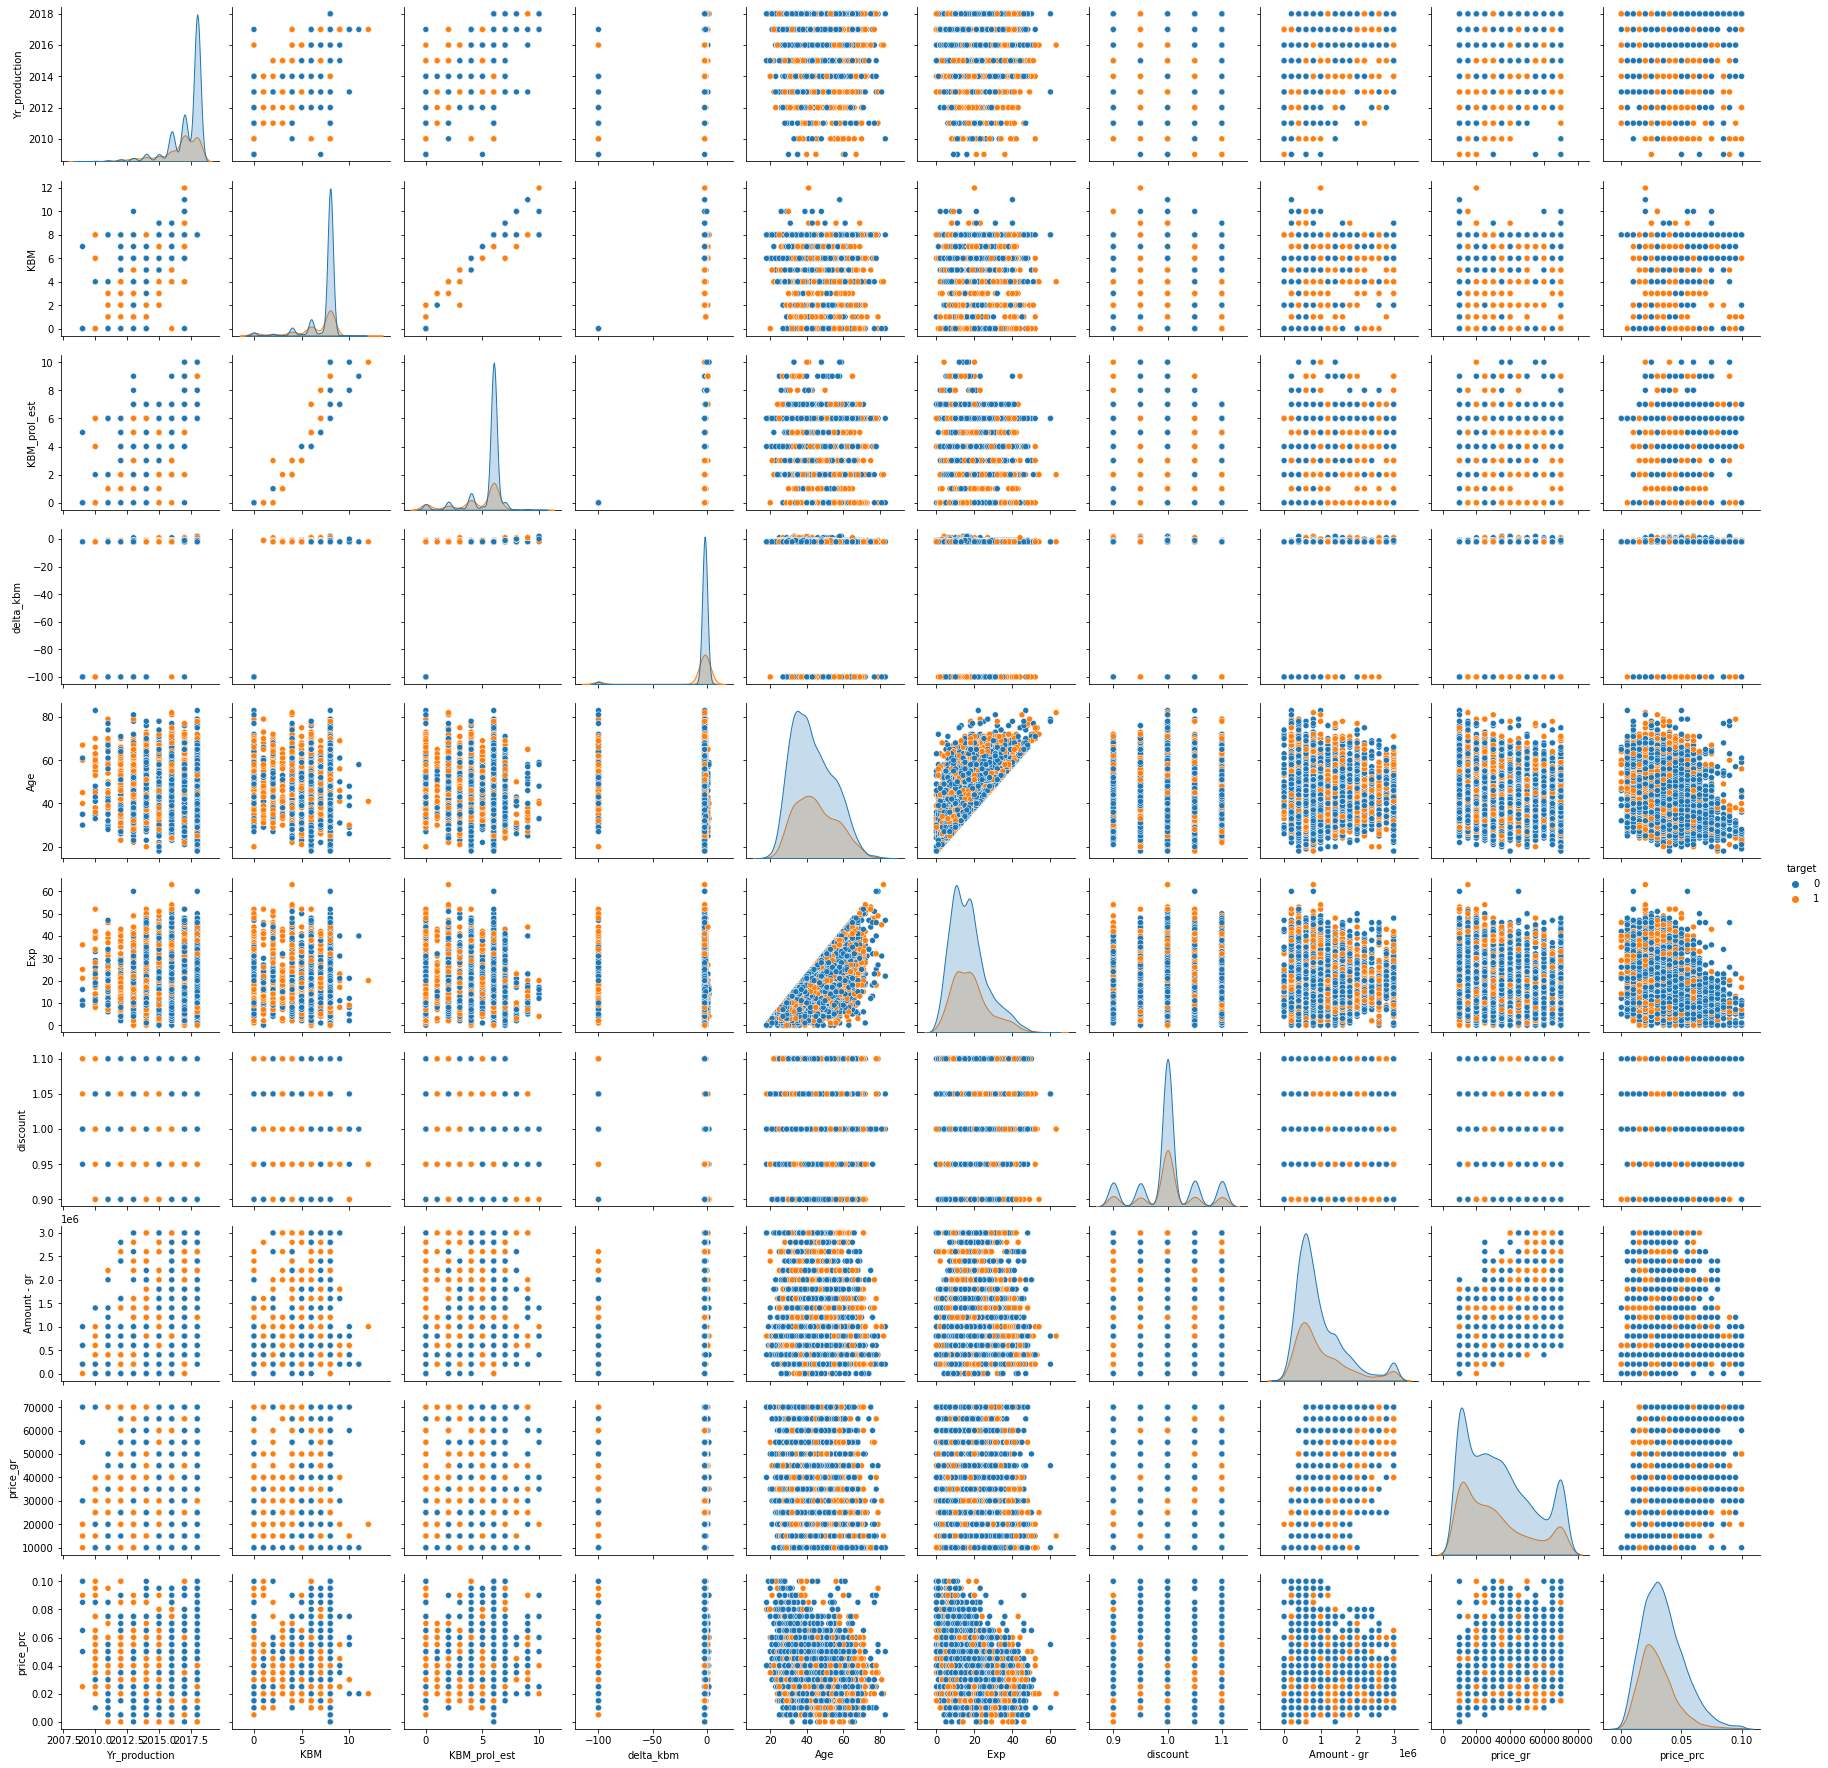

In [33]:
sns.pairplot(data_train[num_cols], hue='target')

In [89]:
dummy_features = pd.get_dummies(data_train[cat_cols], drop_first=True)

num_cols = num_cols[:-1]

X = pd.concat([data_train[num_cols], dummy_features], axis=1)
y = data_train['target']

In [35]:
X.head(3)

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,price_gr,price_prc,...,Bank_Без банка,Bank_Сетелем,channel - map_Розница,category_NB 2+,category_RN,category_RN sppg,"kvs_type_Ограничение по стажу и возрасту, без ограничения количества лиц",sex_M,OSAGO_clnt_1,premium_car_1
0,2018,8,6,-2,42,24,1.00,1400000,55000,0.040,...,0,0,0,0,0,0,0,1,0,0
1,2016,8,6,-2,41,4,1.05,200000,10000,0.010,...,0,0,0,0,1,0,0,1,0,0
2,2018,8,6,-2,49,20,0.95,400000,30000,0.065,...,0,0,0,0,0,0,0,0,1,0


In [36]:
y.value_counts()

0    5218
1    2370
Name: target, dtype: int64

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=r_seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5691, 346)
(1897, 346)
(5691,)


In [60]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [61]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.6366910013461737
precision: 0.40314769975786924
recall: 0.5625
f1: 0.4696755994358251
logloss: 13.691910411442233


In [96]:
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [97]:
X_train

,Yr_production,KBM,KBM_prol_est,delta_kbm,Age,Exp,discount,Amount - gr,price_gr,Filial_Волгоградский,...,Bank_Без банка,Bank_Сетелем,channel - map_Розница,category_NB 2+,category_RN,category_RN sppg,"kvs_type_Ограничение по стажу и возрасту, без ограничения количества лиц",sex_M,OSAGO_clnt_1,premium_car_1
862,-0.594715,-1.560244,-1.816150,0.1817,-1.830585,-1.562800,-0.006931,-0.544096,-0.389953,0,...,0,0,0,0,1,0,0,1,0,0
2275,0.681260,0.492429,0.470258,0.1817,1.176089,0.291769,-0.006931,-0.544096,-1.151004,0,...,1,0,0,0,0,0,0,0,1,0
4774,0.681260,0.492429,0.470258,0.1817,-0.327248,-0.017326,-0.006931,0.634158,1.132148,0,...,0,0,0,0,0,0,0,0,0,0
130,0.043272,0.492429,0.470258,0.1817,-0.415680,-0.841579,-0.006931,-0.544096,-1.151004,0,...,0,0,0,0,1,0,0,1,1,0
1776,0.681260,0.492429,0.470258,0.1817,0.910794,0.394801,-1.979275,-0.544096,-1.151004,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,0.043272,0.492429,0.470258,0.1817,-1.653722,-1.253705,-1.979275,-0.838659,-0.897320,0,...,0,0,0,0,0,0,0,0,0,0
2206,0.681260,0.492429,0.470258,0.1817,-0.857838,-0.120357,-0.006931,-0.249533,-1.151004,0,...,1,0,1,0,0,0,0,1,0,0
5088,0.681260,0.492429,0.470258,0.1817,-0.857838,-0.223389,-0.006931,-0.249533,-1.151004,0,...,1,0,0,0,0,0,0,1,1,0
6051,0.681260,0.492429,0.470258,0.1817,0.291773,-0.326421,-0.006931,0.634158,0.371097,0,...,0,0,0,0,0,0,0,0,1,0


In [98]:
estimator = LogisticRegression(max_iter=10000)
params = [{
    'penalty' : ['l1','l2'],
    'solver' : ['liblinear', 'saga'],
    'C' : [100, 10, 1, 0.1, 0.01, 0.001],
    'class_weight': ['balanced', None]},
    
     {'penalty' : ['l2'],
    'solver' : ['newton-cg', 'lbfgs','sag'],
    'C' : [100, 10, 1, 0.1, 0.01, 0.001],
     'class_weight': ['balanced', None]}]

grid_search = GridSearchCV(estimator, params, cv=5, n_jobs=-1, scoring='roc_auc', error_score="raise" )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'class_weight': ['balanced', None],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [100, 10, 1, 0.1, 0.01, 0.001],
                          'class_weight': ['balanced', None], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'sag']}],
             scoring='roc_auc')

In [102]:
print(grid_search.best_params_)
print(grid_search.best_score_)
best_params = grid_search.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
0.733715498871379


In [103]:
round(grid_search.score(X_test,y_test),4)

0.7379

In [106]:
grid_clf = LogisticRegression(**best_params)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)
y_score = grid_clf.predict_proba(X_test)[:,1]

In [107]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.7379111101914978
precision: 0.47596153846153844
recall: 0.6677908937605397
f1: 0.5557894736842105
logloss: 11.52524727593992


In [62]:
data_cat[['OSAGO_clnt', 'premium_car']] = data_cat[['OSAGO_clnt', 'premium_car']].astype("string")


In [63]:
data_train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7588 entries, 0 to 7597
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Filial           7588 non-null   object
 1   Type_ts          7588 non-null   object
 2   passport_region  7588 non-null   object
 3   VIP              7588 non-null   object
 4   Brand            7588 non-null   object
 5   Model            7588 non-null   object
 6   GAP              7588 non-null   object
 7   married          7588 non-null   object
 8   deduct           7588 non-null   object
 9   deduct_amount    7588 non-null   object
 10  product          7588 non-null   object
 11  Bank             7588 non-null   object
 12  channel - map    7588 non-null   object
 13  category         7588 non-null   object
 14  kvs_type         7588 non-null   object
 15  sex              7588 non-null   object
 16  OSAGO_clnt       7588 non-null   object
 17  premium_car      7588 non-null   

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    data_train[cat_cols+num_cols], y, stratify=y, test_size=0.25, random_state=r_seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5691, 28)
(1897, 28)
(5691,)


In [83]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)]
        )



In [84]:
y_train

6692    0
6752    1
6666    0
3150    0
7021    1
       ..
254     0
2604    0
3663    0
3652    1
218     1
Name: target, Length: 5691, dtype: int64

In [85]:
#pipeline = Pipeline([("preprocessor", preprocessor),
#                    ("clf", LogisticRegression())])
#
#params = [{
#    'clf__penalty': ['l1', 'l2'],
#    'clf__solver': ['liblinear', 'saga'],
#    'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
#    'clf__class_weight': ['balanced', None]},
#
#    {'clf__penalty': ['l2'],
#     'clf__solver': ['newton-cg', 'lbfgs', 'sag'],
#     'clf__C': [100, 10, 1, 0.1, 0.01, 0.001],
#     'clf__class_weight': ['balanced', None]}]
#
#grid_pipeline = GridSearchCV(pipeline, params,  cv=5, n_jobs=-1, scoring='roc_auc')
#grid_pipeline.fit(X_train,y_train)
#grid_pipeline.best_params_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


{'clf__C': 100,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear'}

In [86]:
print(grid_pipeline.best_params_)
print(grid_pipeline.best_score_)

{'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
nan


In [99]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
0.733715498871379


In [94]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7336881454572397


In [ ]:
## When use pipeline class
#pipeline = Pipeline([( "scaler" , StandardScaler()),
#                       ("rf",RandomForestClassifier())])
## import Grid Search class
#from sklearn.model_selection import GridSearchCV
## make lists of different parameters to check
#parameters = {
#  'n_estimators':[1,10,100,1000],
#  'min_samples_split': [2,3,4,5]
#  }
## initialize
#grid_pipeline = GridSearchCV(pipeline,parameters)
## fit
#grid_pipeline.fit(X_train,y_train)
#grid_pipeline.best_params_

In [ ]:
#numeric_features = ["age", "fare"]
#numeric_transformer = Pipeline(
#    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
#)
#
#categorical_features = ["embarked", "sex", "pclass"]
#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
#
#preprocessor = ColumnTransformer(
#    transformers=[
#        ("num", numeric_transformer, numeric_features),
#        ("cat", categorical_transformer, categorical_features),
#    ]
#)

In [ ]:
#clf = Pipeline(
#    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
#)
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
#clf.fit(X_train, y_train)
#print("model score: %.3f" % clf.score(X_test, y_test))